# Structured data EVALUATION

## Import 

In [1]:
# What version of Python do you have?
import sys
import pandas as pd
import numpy as np
import math
from PIL import Image, ImageOps
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from skimage import exposure

from tqdm import tqdm

import gc
import copy
import cv2

# import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from pathlib import Path

In [2]:
# Import Library.
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [3]:
from keras.preprocessing.image import load_img, img_to_array, smart_resize, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import get_file, plot_model, to_categorical

In [4]:
#IMPORT ALL LAYERS AND KERAS/TENSORFLOW PARAMS
from keras import layers
from keras.layers import StringLookup, CategoryEncoding, GlobalMaxPooling2D, Rescaling, SeparableConv2D, BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten, Input, Concatenate, Add, AveragePooling2D, GlobalAveragePooling2D, AveragePooling1D, Reshape
from keras.models import Sequential, Model
from keras.activations import relu,leaky_relu
from keras.initializers import RandomNormal
from keras.regularizers import l2, l1, l1_l2
import keras_ocr 

In [5]:
print(f"Python {sys.version}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Keras Version: {np.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Tensor Flow Version: 2.8.0
Keras Version: 2.8.0
Pandas 1.3.5
Keras Version: 1.22.3

GPU is available


In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
!nvidia-smi

Thu Apr  7 12:27:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    30W / 350W |   1262MiB / 12288MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Utils / Functions

### UTILS PATHS

In [8]:
checkpointPath = Path('Outputs/StructuredData/CHECKPOINTS/')
graphPath = Path('Outputs/StructuredData/GRAPHS/')
pathSavedModel = Path('Outputs/StructuredData/MODELS-PB/')
plotpath = Path('Outputs/StructuredData/PLTS/')


pathDatabaseSD = Path('../COVID_19_DATA_FEATURES.csv')
pathDatabaseSD_template = Path('../COVID_19_DATA_FEATURES_TEMPLATE.csv')
databasePathIMAGES = Path('../COVID-19-CHEST-ONLY/')

In [9]:
checkpointPath.mkdir(parents=True, exist_ok=True)
graphPath.mkdir(parents=True, exist_ok=True)
pathSavedModel.mkdir(parents=True, exist_ok=True)
plotpath.mkdir(parents=True, exist_ok=True)

### RANDOM NUMBER

In [10]:
random_seed = 42

### GLOBAL VARIABLES

In [11]:
IMAGE_SIZE = [224,224]
CLASS_NAMES = ['MILD', 'SEVERE']    #is icu T/F

### FUNCTIONS

In [12]:
def printAndSaveGraphs(pathWsave,nameOfModelGraph, history, Metrics, saveit = True, dpi = 300):

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+nameOfModelGraph+ ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation-HKonly'], loc='upper left')
    if saveit:
        plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + '_loss.png'),dpi=dpi)
    plt.show()

    for met in Metrics:
        # summarize history for accuracy
        plt.plot(history.history[met.name])
        plt.plot(history.history['val_'+met.name])
        plt.title('model '+nameOfModelGraph+ met.name)
        plt.ylabel(met.name)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        if saveit:
            plt.savefig(Path(pathWsave) / Path(nameOfModelGraph + met.name + '.png'),dpi=dpi)
        plt.show()

In [13]:
## REMEMBER TO DEEPCOPY THESE METRICS otherwise it will be summed on, it needs to be clean when used
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    # tf.keras.metrics.Accuracy(name='accuracy'),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="True_Positives"),
    tf.keras.metrics.TrueNegatives(name="True_Negatives"),
    tf.keras.metrics.FalsePositives(name="False_Positives"),
    tf.keras.metrics.FalseNegatives(name="False_Negatives"),
]

## IMPORT STRUCTURED DATA

In [14]:
# read in all our data
COVID19 = pd.read_csv(pathDatabaseSD)
COVID19 = COVID19.drop(['covid19_statuses'], axis='columns')
print(COVID19.shape)

(1384, 130)


In [15]:
COVID19.head()

,to_patient_id,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,length_of_stay,...,33254-4_pH of Arterial blood adjusted to patient's actual temperature,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy
0,A917122,discharged,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,9,...,NaN,39.0,128.0,NaN,NaN,NaN,NaN,False,True,apixaban
1,A387558,deceased,"(74,90]",MALE,1/1/1901,Inpatient Visit,True,No,NaN,15,...,7.39,NaN,199.0,NaN,NaN,NaN,NaN,True,True,apixaban
2,A968238,deceased,"(74,90]",MALE,1/5/1901,Inpatient Visit,True,Yes,28.0,28,...,7.45,54.0,134.0,NaN,NaN,NaN,NaN,False,True,not documented
3,A106133,deceased,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,4,...,NaN,NaN,265.0,63.0,31.0,153.0,36.0,True,True,not documented
4,A300871,deceased,"(74,90]",FEMALE,1/1/1901,Inpatient Visit,False,No,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented


In [16]:
print("number of NaN: " + str(COVID19.isna().sum().sum()))
print("size of DB: " + str(COVID19.size))

print('percentage of NaN: '+str((COVID19.isna().sum().sum()/COVID19.size)*100))


number of NaN: 48273
size of DB: 179920
percentage of NaN: 26.83025789239662


In [17]:
COVID19_template = pd.read_csv(pathDatabaseSD_template)
print(COVID19_template.shape)

(131, 5)


In [18]:
COVID19_template.head()

,column_name,column_type,is_chart_abstracted,column_counts,description
0,to_patient_id,string,NaN,NaN,TCIA patient identifier
1,covid19_statuses,string,NaN,{'positive': 1479},COVID-19 status as determined through either p...
2,last.status,string,NaN,"{'deceased': 194, 'discharged': 1285}",For the selected visit the status of the patient
3,age.splits,string,NaN,"{'(59,74]': 376, '(74,90]': 297, '[18,59]': 806}",Age intervals (in years) at time of admission;...
4,gender_concept_name,string,NaN,"{'FEMALE': 635, 'MALE': 810}",Documented gender in the EHR (Electronic Healt...


### DATE PARSING

In [19]:
print(COVID19['visit_start_datetime'].head())
print(COVID19['visit_start_datetime'].dtype)

0    1/1/1901
1    1/1/1901
2    1/5/1901
3    1/1/1901
4    1/1/1901
Name: visit_start_datetime, dtype: object
object


In [20]:
date_Parsed_COVID19 = pd.to_datetime(COVID19['visit_start_datetime'],infer_datetime_format=True, exact=True)
# date_Parsed_COVID19 = pd.to_datetime(COVID19_data['visit_start_datetime'],format='%m/%d/%y', exact=False)
print(date_Parsed_COVID19)

0      1901-01-01
1      1901-01-01
2      1901-01-05
3      1901-01-01
4      1901-01-01
          ...    
1379   1901-01-01
1380   1901-01-01
1381   1901-01-01
1382   1901-01-01
1383   1901-01-01
Name: visit_start_datetime, Length: 1384, dtype: datetime64[ns]


In [21]:
COVID19['visit_start_datetime'] = date_Parsed_COVID19

In [22]:
COVID19.head()

,to_patient_id,last.status,age.splits,gender_concept_name,visit_start_datetime,visit_concept_name,is_icu,was_ventilated,invasive_vent_days,length_of_stay,...,33254-4_pH of Arterial blood adjusted to patient's actual temperature,30341-2_Erythrocyte sedimentation rate,2345-7_Glucose [Mass/volume] in Serum or Plasma,13457-7_Cholesterol in LDL [Mass/volume] in Serum or Plasma by calculation,13458-5_Cholesterol in VLDL [Mass/volume] in Serum or Plasma by calculation,2571-8_Triglyceride [Mass/volume] in Serum or Plasma,2085-9_Cholesterol in HDL [Mass/volume] in Serum or Plasma,therapeutic.exnox.Boolean,therapeutic.heparin.Boolean,Other.anticoagulation.therapy
0,A917122,discharged,"(74,90]",FEMALE,1901-01-01,Inpatient Visit,False,No,NaN,9,...,NaN,39.0,128.0,NaN,NaN,NaN,NaN,False,True,apixaban
1,A387558,deceased,"(74,90]",MALE,1901-01-01,Inpatient Visit,True,No,NaN,15,...,7.39,NaN,199.0,NaN,NaN,NaN,NaN,True,True,apixaban
2,A968238,deceased,"(74,90]",MALE,1901-01-05,Inpatient Visit,True,Yes,28.0,28,...,7.45,54.0,134.0,NaN,NaN,NaN,NaN,False,True,not documented
3,A106133,deceased,"(74,90]",FEMALE,1901-01-01,Inpatient Visit,False,No,NaN,4,...,NaN,NaN,265.0,63.0,31.0,153.0,36.0,True,True,not documented
4,A300871,deceased,"(74,90]",FEMALE,1901-01-01,Inpatient Visit,False,No,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,not documented


### PARSING VALUES OF OTHER FEATURES

kidney_replacement_therapy ONLY YES... OTHER ARE NO OR UNKOWN?


kidney_transplant ONLY YES... OTHER ARE NO OR UNKOWN?

In [23]:
# ONE HOT ENCODER?

#For HFrEF, documented ICD-10 code for HFrEF or echocardiogram documenting reduced ejection fraction (reduced EF is <40%, 40% or higher is preserved EF). For HFpEF, documented ICD-10 code for HFpEF or echocardiogram documenting diastolic dysfunction.
hf_ef_v = {'HFpEF': 1, 'HFrEF': 2, 'No': 0}
COVID19 = COVID19.replace({'hf_ef_v': hf_ef_v})

In [24]:
COVID19 = COVID19.replace({'Yes':True,'No':False})

In [25]:
#last status: discharged = True, deceased = False
last_s = {'discharged': True, 'deceased': False}
COVID19 = COVID19.replace({'last.status': last_s})


In [26]:
#GENDER: female = True, male = False
gender = {'FEMALE': True, 'MALE': False}
COVID19 = COVID19.replace({'gender_concept_name': gender})


In [27]:
#AGE: [18,59] = 0, (59,74] = 1, (74,90] = 2
age = {'[18,59]': (59+18)/2, '(59,74]': (74+60)/2, '(74,90]': (90+75)/2}
COVID19 = COVID19.replace({'age.splits': age})

In [28]:
# ONE HOT ENCODER?  -   DONE

# #visit_concept: Emergency Room Visit = 0, Inpatient Visit = 1, Outpatient Visit = 2
# visit_concept = {'Emergency Room Visit': 0, 'Inpatient Visit': 1, 'Outpatient Visit': 2}
# COVID19 = COVID19.replace({'visit_concept_name': visit_concept})

# #one hot encoder Hospitals
# VISIT= ['Emergency Room Visit','Inpatient Visit','Outpatient Visit']

# mapping = {}
# for x in range(len(VISIT)):
#     mapping[VISIT[x]] = x

# takename = copy.deepcopy(COVID19['visit_concept_name'])
# for x in range(len(takename)):
#     takename[x] = mapping[takename[x]]


# one_h_enc = to_categorical(takename)
# COVID19['Emergency Room Visit'] = one_h_enc[:,0]
# COVID19['Inpatient Visit'] = one_h_enc[:,1]
# COVID19['Outpatient Visit'] = one_h_enc[:,2]

# COVID19 = COVID19.drop(['visit_concept_name'], axis='columns')


In [29]:
#INVASIVE VENT DAYS     IF VENTILATED = TRUE: SET NUMBER IF NOT THEN = 0
COVID19.loc[COVID19['was_ventilated'] == False, 'invasive_vent_days'] = 0
# print(db_COVID19['invasive_vent_days'].isnull().sum())  #save this col

In [30]:
# ONE HOT ENCODER?

# #SMOKING STATUS :  Never = 0, Former = 1, Current = 2
# smoking_status = {'Current': 2, 'Former': 1, 'Never': 0}
# COVID19 = COVID19.replace({'smoking_status_v': smoking_status})

#one hot encoder Hospitals
SMOKING= ['Current','Former','Never','Unknown']

mapping = {}
for x in range(len(SMOKING)):
    mapping[SMOKING[x]] = x

takename = copy.deepcopy(COVID19['smoking_status_v'])

takename = takename.fillna('Unknown')
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['Current Smoker'] = one_h_enc[:,0]
COVID19['Former Smoker'] = one_h_enc[:,1]
COVID19['Never Smoker'] = one_h_enc[:,2]
COVID19['Unknown Smoker'] = one_h_enc[:,3]

COVID19 = COVID19.drop(['smoking_status_v'], axis='columns')

In [31]:
# ONE HOT ENCODER?      NO

#URINE PROTEIN: Normal = True, Abnormal = False
urine = {'Normal': False, 'Abnormal': True}
COVID19 = COVID19.replace({'Urine.protein': urine})


In [32]:
# ONE HOT ENCODER?

# #Other Anticoagoulation therapy: 'apixaban': 0, 'argatroban': 1, 'dabigatran': 2, 'multiple': 3, 'not documented': 4, 'rivaroxaban': 5, 'wafarin': 6
# other_anticoag = {'apixaban': 0, 'argatroban': 1, 'dabigatran': 2, 'multiple': 3, 'not documented': 4, 'rivaroxaban': 5, 'wafarin': 6}
# COVID19 = COVID19.replace({'Other.anticoagulation.therapy': other_anticoag})


#one hot encoder Hospitals
ANTICOUAGULATION= ['apixaban','argatroban','dabigatran','multiple','not documented','rivaroxaban','wafarin','NO']

mapping = {}
for x in range(len(ANTICOUAGULATION)):
    mapping[ANTICOUAGULATION[x]] = x

takename = copy.deepcopy(COVID19['Other.anticoagulation.therapy'])
takename = takename.fillna('NO')
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['anticoagulation_therapy_apixaban'] = one_h_enc[:,0]
COVID19['anticoagulation_therapy_argatroban'] = one_h_enc[:,1]
COVID19['anticoagulation_therapy_dabigatran'] = one_h_enc[:,2]
COVID19['anticoagulation_therapy_multiple'] = one_h_enc[:,3]
COVID19['anticoagulation_therapy_not_documented'] = one_h_enc[:,4]
COVID19['anticoagulation_therapy_rivaroxaban'] = one_h_enc[:,5]
COVID19['anticoagulation_therapy_wafarin'] = one_h_enc[:,6]
COVID19['NO_anticoagulation_therapy'] = one_h_enc[:,7]

COVID19 = COVID19.drop(['Other.anticoagulation.therapy'], axis='columns')

In [34]:
# ONE HOT ENCODER?

#SMOKING STATUS :  Never = 0, Former = 1, Current = 2
is_ICU = {False: 'MILD', True: 'SEVERE'}
COVID19 = COVID19.replace({'is_icu': is_ICU})

#one hot encoder Hospitals
ICU= ['MILD','SEVERE']

mapping = {}
for x in range(len(ICU)):
    mapping[ICU[x]] = x

takename = copy.deepcopy(COVID19['is_icu'])
for x in range(len(takename)):
    takename[x] = mapping[takename[x]]


one_h_enc = to_categorical(takename)
COVID19['MILD'] = one_h_enc[:,0]
COVID19['SEVERE'] = one_h_enc[:,1]

COVID19 = COVID19.drop(['is_icu'], axis='columns')

## Extract X and Y

In [35]:
#CHECK PROGNOSIS
# X_full = pd.DataFrame(COVID19_dataHK[['ImageFile']])
X_full = pd.DataFrame(COVID19.drop(['MILD','SEVERE'], axis='columns'))
#without images:
Y_full = pd.DataFrame(COVID19[['MILD','SEVERE']])

In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(X_full,Y_full, test_size=0.2,shuffle=True, random_state=random_seed)


print("Training set shape X : "+str(X_train.shape)+"   y : "+str(Y_train.shape))
print("Validation set shape X : "+str(X_val.shape)+"   y : "+str(Y_val.shape))

Training set shape X : (1107, 139)   y : (1107, 2)
Validation set shape X : (277, 139)   y : (277, 2)


In [37]:
#MILD in Y train vs SEVERE in Y train
print('Y train: \n'+str(Y_train.sum()))

#MILD in Y val vs SEVERE in Y val
print('Y train: \n'+str(Y_val.sum()))

Y train: 
MILD      893.0
SEVERE    214.0
dtype: float32
Y train: 
MILD      231.0
SEVERE     46.0
dtype: float32


### Data imputation for missing values

In [38]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, confusion_matrix

In [39]:
# function to find the mean value of the column
def meanOfCol(db,col_names):
    for col in col_names:
        n = 0
        coln = pd.DataFrame(db[col])
        s = coln.sum().sum()
        n = len(coln)-coln.isnull().sum().sum()
        m = s/n
        db[col] = db[col].fillna(m)
    return db

In [40]:
# search all feature that are numeric
nameColsNumber = list(X_full.select_dtypes(exclude=['string','object','bool','datetime']).columns)

# Generates the mean of the column and change NAN values with the mean of the column
X_train = meanOfCol(X_train,nameColsNumber)
X_val = meanOfCol(X_val,nameColsNumber)
# X_test = meanOfCol(X_test,nameColsNumber)     # only if testet is needed

#### Imputation of T/F values NaN

In [41]:
X_train = X_train.fillna(-1)
X_val = X_val.fillna(-1)

### Normalization of the values

If don't care is needed this has to be done before the don't care value setting only to the present values

In [42]:
# if Image paths are still used there can not be a normalization so drop the path col and add it later
X_tr_ID = X_train['to_patient_id']
X_vl_ID = X_val['to_patient_id']

X_tr_TIME = X_train['visit_start_datetime']
X_vl_TIME = X_val['visit_start_datetime']

X_tr_CONCEPT = X_train['visit_concept_name']
X_vl_CONCEPT = X_val['visit_concept_name']


X_train = X_train.drop(['to_patient_id','visit_start_datetime','visit_concept_name'], axis='columns')
X_val = X_val.drop(['to_patient_id','visit_start_datetime','visit_concept_name'], axis='columns')

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns,index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns,index=X_val.index)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns,index=X_test.index)    # only if testset is needed

In [44]:
X_train['to_patient_id'] = X_tr_ID
X_val['to_patient_id'] = X_vl_ID

X_train['visit_start_datetime'] = X_tr_TIME
X_val['visit_start_datetime'] = X_vl_TIME

X_train['visit_concept_name'] = X_tr_CONCEPT
X_val['visit_concept_name'] = X_vl_CONCEPT

In [45]:
X_train.head()

,last.status,age.splits,gender_concept_name,was_ventilated,invasive_vent_days,length_of_stay,Acute.Hepatic.Injury..during.hospitalization.,Acute.Kidney.Injury..during.hospitalization.,Urine.protein,kidney_replacement_therapy,...,anticoagulation_therapy_argatroban,anticoagulation_therapy_dabigatran,anticoagulation_therapy_multiple,anticoagulation_therapy_not_documented,anticoagulation_therapy_rivaroxaban,anticoagulation_therapy_wafarin,NO_anticoagulation_therapy,to_patient_id,visit_start_datetime,visit_concept_name
1260,1.0,0.000000,1.0,0.0,0.000,0.031579,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,A349670,1901-01-01,Inpatient Visit
1156,1.0,0.647727,0.5,0.0,0.000,0.063158,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,A330665,1900-12-31,Inpatient Visit
820,1.0,1.000000,0.5,0.0,0.000,0.052632,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,A610315,1901-01-01,Inpatient Visit
704,1.0,0.000000,1.0,1.0,0.275,0.231579,0.5,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,A494186,1901-01-01,Inpatient Visit
1097,1.0,0.000000,0.5,0.0,0.000,0.042105,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,A005097,1900-12-31,Inpatient Visit


## MLP

In [46]:
def create_mlp(dim, regression=False):
    #model definition
    model = Sequential()
    model.add(Dense(32,input_dim=dim,activation='relu'))
    # model.add(Dropout(0.7))
    model.add(Dense(16,activation='relu'))
    # model.add(Dropout(0.8))
    model.add(Dense(8,activation='relu'))
    # model.add(Dropout(0.8))
    model.add(Dense(4,activation='relu'))
    # model.add(Dropout(0.5))
    #can continue the model

    if regression:
        model.add(Dense(2,activation='sigmoid'))
    # else:
        # model.add(Flatten())

    return model

In [47]:
def create_mlp_winner_hack(dim, regression=False):
    #model definition
    model = Sequential()
    model.add(Dense(64,input_dim=dim,activation='relu'))
    # model.add(Dropout(0.7))
    model.add(Dense(64,activation='relu'))
    # model.add(Dropout(0.8))
    model.add(Dense(32,activation='relu'))

    if regression:
        model.add(Dense(2,activation='sigmoid'))
    # else:
        # model.add(Flatten())

    return model

In [48]:
mlpOnly = create_mlp(X_train.drop(['to_patient_id','visit_start_datetime','last.status','visit_concept_name','invasive_vent_days','Acute.Hepatic.Injury..during.hospitalization.','Acute.Kidney.Injury..during.hospitalization.'], axis='columns').shape[1], regression=True)

In [49]:
mlpOnly.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                4256      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
Total params: 4,966
Trainable params: 4,966
Non-trainable params: 0
_________________________________________________________________


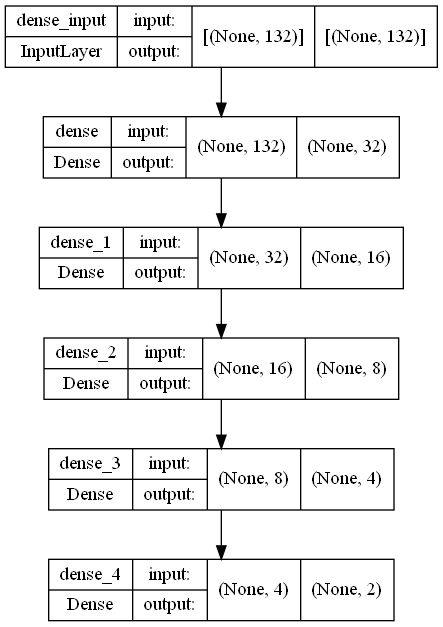

In [50]:
plot_model(mlpOnly, show_shapes=True, show_layer_names=True)

In [51]:
metrics = copy.deepcopy(METRICS)


mlpOnly.compile(
        # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-05),
        optimizer=tf.keras.optimizers.Adam(),
        # optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3, decay=1e-5),
        loss="binary_crossentropy",
        metrics=metrics,
)

# CREATE CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(
						checkpointPath / Path('MLPout'), 
						monitor='val_binary_accuracy', verbose=1, 
						save_best_only=True, mode='max')
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
# 						'MultilayerFusion/callbacks/model_DS_callback_DS', 
# 						monitor='val_binary_accuracy', verbose=1, 
# 						save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = mlpOnly.fit(
        x = X_train.drop(['to_patient_id','visit_start_datetime','last.status','visit_concept_name','invasive_vent_days','Acute.Hepatic.Injury..during.hospitalization.','Acute.Kidney.Injury..during.hospitalization.'],axis='columns'),
        y = Y_train,
        epochs = 200,
        validation_data = [X_val.drop(['to_patient_id','visit_start_datetime','last.status','visit_concept_name','invasive_vent_days','Acute.Hepatic.Injury..during.hospitalization.','Acute.Kidney.Injury..during.hospitalization.'],axis='columns'),Y_val],
        callbacks = callbacks_list,    #some problems with DS layers and callbacks
)
# history = model.fit(
#         x = train_data_generator,
#         epochs = 200,
#         validation_data = valid_data_generator,
#         callbacks = callbacks_list,    #some problems with DS layers and callbacks
# )

Epoch 1/200
23/35 [==================>...........] - ETA: 0s - loss: 0.6173 - binary_accuracy: 0.7500 - precision: 0.7341 - recall: 0.7840 - True_Positives: 577.0000 - True_Negatives: 527.0000 - False_Positives: 209.0000 - False_Negatives: 159.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.78540, saving model to Outputs\StructuredData\CHECKPOINTS\MLPout
INFO:tensorflow:Assets written to: Outputs\StructuredData\CHECKPOINTS\MLPout\assets
35/35 [==============================] - 2s 23ms/step - loss: 0.5861 - binary_accuracy: 0.7733 - precision: 0.7615 - recall: 0.7958 - True_Positives: 881.0000 - True_Negatives: 831.0000 - False_Positives: 276.0000 - False_Negatives: 226.0000 - val_loss: 0.4841 - val_binary_accuracy: 0.7854 - val_precision: 0.7755 - val_recall: 0.8035 - val_True_Positives: 1112.0000 - val_True_Negatives: 1062.0000 - val_False_Positives: 322.0000 - val_False_Negatives: 272.0000
Epoch 2/200
24/35 [===================>..........] - ETA: 0s - loss: 0.4810 - binary_

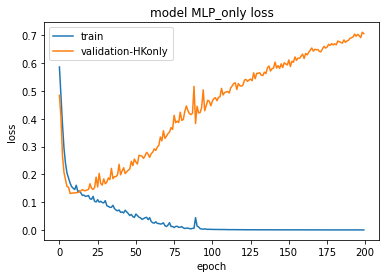

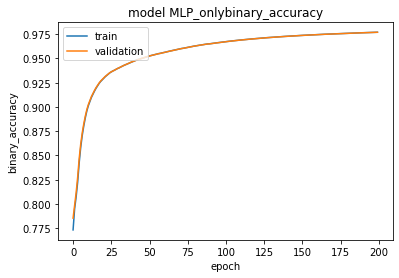

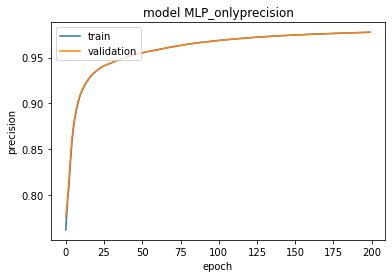

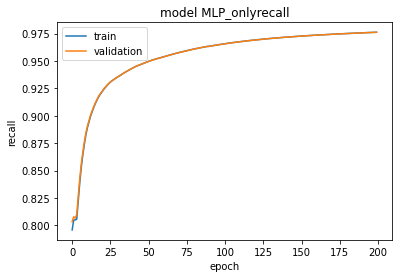

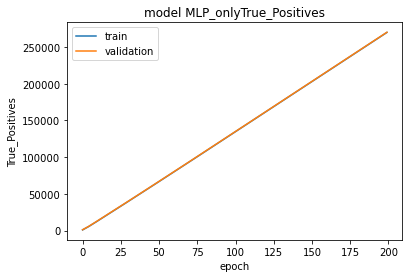

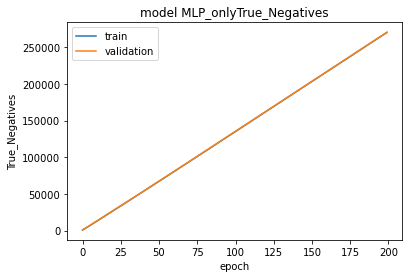

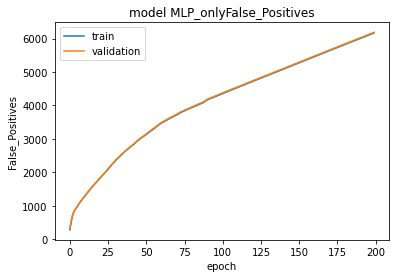

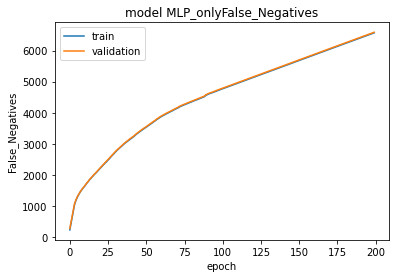

In [52]:
printAndSaveGraphs(graphPath,'MLP_only',history=history, Metrics=METRICS)
hist_df = pd.DataFrame(history.history)

# save to csv: 
hist_csv_file = graphPath / Path('MLP_only.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [53]:
bestPt = 'Outputs/StructuredData/OutVALUES'
model = tf.keras.models.load_model(checkpointPath / Path('MLPout'))

evaluation = model.evaluate(x = X_val.drop(['to_patient_id','visit_start_datetime','last.status','visit_concept_name','invasive_vent_days','Acute.Hepatic.Injury..during.hospitalization.','Acute.Kidney.Injury..during.hospitalization.'],axis='columns'), y = Y_val)

evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open(bestPt + '/MLP.txt', 'w') as f:
    f.write('MLP'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')

9/9 [==============================] - 0s 3ms/step - loss: 0.7062 - binary_accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - True_Positives: 259.0000 - True_Negatives: 259.0000 - False_Positives: 18.0000 - False_Negatives: 18.0000
{'loss': 0.7061761021614075, 'binary_accuracy': 0.9350180625915527, 'precision': 0.9350180625915527, 'recall': 0.9350180625915527, 'True_Positives': 259.0, 'True_Negatives': 259.0, 'False_Positives': 18.0, 'False_Negatives': 18.0}


In [54]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_absolute_error

evaluation = model.evaluate(X_val.drop(['to_patient_id','visit_start_datetime','last.status','visit_concept_name','invasive_vent_days','Acute.Hepatic.Injury..during.hospitalization.','Acute.Kidney.Injury..during.hospitalization.'],axis='columns'), Y_val)

preds = model.predict(X_val.drop(['to_patient_id','visit_start_datetime','last.status','visit_concept_name','invasive_vent_days','Acute.Hepatic.Injury..during.hospitalization.','Acute.Kidney.Injury..during.hospitalization.'],axis='columns'))

ypreds = np.argmax(preds, axis=1)
yground = np.argmax(Y_val.to_numpy(), axis=1)

score = accuracy_score(yground, ypreds)
print('accuracy: ', score)

loss = log_loss(yground, ypreds)
print('log_loss: ', loss)

precision = precision_score(yground, ypreds)
print('precision: ', precision)

recall = recall_score(yground, ypreds)
print('recall: ', recall)

cmatrix = confusion_matrix(yground, ypreds)
print(cmatrix)


evaluation = dict(zip(model.metrics_names,evaluation))
print(evaluation)
with open('CNN_MLP_FEATURE_FUSION_90_10.txt', 'w') as f:
    f.write('MLP AND CNN FUSION FEATURES: 90 VAL: 10'+'\n\n')
    for k, v in evaluation.items():
        f.write(str(k) + ' >>> '+ str(v) + '\n\n')
    f.write('MLP AND CNN FUSION FEATURES: 90 VAL: 10'+'\n\n')
    f.write('SKLEARN METRICS:')
    f.write(str('Loss') + ' >>> '+ str(loss) + '\n\n')
    f.write(str('Accuracy') + ' >>> '+ str(score) + '\n\n')
    f.write(str('Precision') + ' >>> '+ str(precision) + '\n\n')
    f.write(str('Recall') + ' >>> '+ str(recall) + '\n\n')
    f.write(str('Confusion Matrix') + ' >>> '+ str(cmatrix) + '\n\n')

9/9 [==============================] - 0s 4ms/step - loss: 0.7062 - binary_accuracy: 0.9350 - precision: 0.9350 - recall: 0.9350 - True_Positives: 259.0000 - True_Negatives: 259.0000 - False_Positives: 18.0000 - False_Negatives: 18.0000
accuracy:  0.9350180505415162
log_loss:  2.2444143418518907
precision:  0.85
recall:  0.7391304347826086
[[225   6]
 [ 12  34]]
{'loss': 0.7061761021614075, 'binary_accuracy': 0.9350180625915527, 'precision': 0.9350180625915527, 'recall': 0.9350180625915527, 'True_Positives': 259.0, 'True_Negatives': 259.0, 'False_Positives': 18.0, 'False_Negatives': 18.0}


## XGBOOST

## TRAIN ON DATA